# 3D Segmentation of Brain Tumor

This document is to propose a 2D methodology instead of treating it as a 3D input.


## Loading the Dataset
The dataset used is the BraTS 2020 Dataset.

The Dataset Contains the Following Scans per case:

T1: T1-weighted, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.

T1c: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.

T2: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.

FLAIR: T2-weighted FLAIR image, axial, coronal, or sagittal 2D acquisitions, 2–6 mm slice thickness.

So for training T1ce, T2 and FLAIR will be used.

### Importing all dependencies

In [1]:
# Previewing the MRI Data
# TODO: Collect all imports later and add notes next to them
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from os import path, listdir
from monai.data import Dataset, list_data_collate, DataLoader, decollate_batch
from monai.transforms import (
    LoadImaged,
    Compose,
    MapTransform,
    Orientationd,
    EnsureTyped,
    ToMetaTensord,  # ? same as ensuretyped?
    EnsureChannelFirstd,
    NormalizeIntensityd,
    Spacingd,
    DivisiblePadd,  # ? For UNet needs to be divisible by?
    RandCropByPosNegLabeld,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    Activations,
    AsDiscrete,
)

from monai.networks.nets import SegResNet, UNet, UNETR
from monai.losses import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric, MeanIoU, compute_meaniou
from monai.inferers import sliding_window_inference

from pytorch_lightning import seed_everything
import torch
from utilities.split_data import train_val_test_dataset

from monai.utils.misc import first

from tqdm import tqdm


c:\Users\ibrah\miniconda3\envs\fyp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed_everything(1607)

2023-01-15 13:47:52,758 - Global seed set to 1607


1607

In [3]:
import gc

def clear_gpu_cache():
    """Clear the PyTorch GPU Allocation if an OOM error occurs.
    """

    try:
        print("Deleting Model")
        global model
        del model
    except NameError as e:
        print(f"Model Already Cleared")

    print("Collecting Garbage")
    gc.collect()
    print("Clearing CUDA Cache")
    torch.cuda.empty_cache()
    print("Done")


## Preparing the Dataset

As per [University of Pennsylvania](https://www.med.upenn.edu/cbica/brats2020/data.html):

All BraTS multimodal scans are available as NIfTI files (.nii.gz) and describe a) native (T1) and b) post-contrast T1-weighted (T1Gd), c) T2-weighted (T2), and d) T2 Fluid Attenuated Inversion Recovery (T2-FLAIR) volumes, and were acquired with different clinical protocols and various scanners from multiple (n=19) institutions, mentioned as data contributors here.

All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1), as described both in the BraTS 2012-2013 TMI paper(opens in a new window) and in the latest BraTS summarizing paper. The provided data are distributed after their pre-processing, i.e., *co-registered to the same anatomical template*, interpolated to the *same resolution (1 mm^3)* and *skull-stripped*.

In [4]:
# Prepare list of All training Cases
TRAINING_DATASET_PATH = r"./MICCAI_BraTS2020_TrainingData"
NAME_MAPPING = r"./MICCAI_BraTS2020_TrainingData/name_mapping.csv"

# Function returns names of cases to be used
train_cases, val_cases, test_cases = train_val_test_dataset(NAME_MAPPING)




          Ratio of Classes -> HGG/Total
          - Training 0.80	| 265 Cases.
          - Validation 0.79	| 67 Cases.
          - Testing 0.78	| 37 Cases.
          
          Total Cases: 369
          


In [5]:
# prepare mapping to convert into PyTorch Dataset
train_cases = [
    {
        "image": [
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t1.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t1ce.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t2.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_flair.nii.gz"),
        ],
        "seg": path.join(
            TRAINING_DATASET_PATH, case, f"{path.split(case)[-1]}_seg.nii.gz"
        ),
    }
    for case in train_cases
]

val_cases = [
    {
        "image": [
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t1.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t1ce.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t2.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_flair.nii.gz"),
        ],
        "seg": path.join(
            TRAINING_DATASET_PATH, case, f"{path.split(case)[-1]}_seg.nii.gz"
        ),
    }
    for case in val_cases
]

#TODO : Test cases can be merged with val
test_cases = [
    {
        "image": [
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t1.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t1ce.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t2.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_flair.nii.gz"),
        ],
        "seg": path.join(
            TRAINING_DATASET_PATH, case, f"{path.split(case)[-1]}_seg.nii.gz"
        ),
    }
    for case in test_cases
]


In [6]:
# One Hot Encoding for Tumor as 3 is skipped in the segmentation masks.
# class ConvertLabelsIntoOneHotd(MapTransform):
#     def __call__(self, data):
#         data_dict = dict(data)
#         for key in self.keys:
#             print(data_dict[key].shape)
#             one_hot_encode_array = [
#                 data_dict[key] == 1,  # Non Enhancing Tumor Core
#                 data_dict[key] == 2,  # Edema Core
#                 data_dict[key] == 4,  # Enhancing Tumor Core
#             ]
#             data_dict[key] = np.stack(one_hot_encode_array, axis=0).astype(np.float32)
#         return data_dict


class ConvertLabelsIntoOneHotd(MapTransform):
    """Takes input tensor of segmentation which contains
    values in set (0,1,2,4) where\n
    0 -> Background/Normal\n
    1 -> Non- Enhancing Tumor Core\n
    2 -> Edema\n
    4 -> Enhancing tumor core\n

    and returns a one hot encoded 3 channel tensor where
    1st Channel -> Whole tumor (1,2 and 4)
    2nd Channel -> Tumor Core (1 and 4)
    3rd Channel -> Enhancing Tumor core (4)
    """
    def __call__(self, data):
        data_dict = dict(data)
        for key in self.keys:
            one_hot_encode_array = [
                torch.logical_or(
                    torch.logical_or(data_dict[key] == 1, data_dict[key] == 2),
                    data_dict[key] == 4,
                ), # Whole Tumor
                torch.logical_or(data_dict[key] == 1, data_dict[key] == 4), # Tumor Core
                data_dict[key] == 4, # Enhancing Core
            ]
            data_dict[key] = torch.stack(one_hot_encode_array, axis=0).astype(torch.float32)
        return data_dict


In [7]:
# Transform data such as from niftii into Tensors
transform_training_dataset = Compose(
    [
        LoadImaged(keys=["image", "seg"]),
        EnsureChannelFirstd(keys=["image"]),
        EnsureTyped(keys=["image", "seg"]),
        ConvertLabelsIntoOneHotd(keys="seg"),
        # Orientationd(keys=["image", "seg"],axcodes='RAS'),
        #! Causes misalignment on Mask Orientationd
        # Spacingd(
        #     keys=["image", "seg"],
        #     pixdim=(1.0, 1.0, 1.0),
        #     mode=("bilinear", "nearest"),
        # ),
        #! Training Dataset Already set to Pixel Dimension of 1mm^3
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandCropByPosNegLabeld(
            keys=["image", "seg"],
            spatial_size=(96,96,96),
            label_key="seg",
            neg=0,
            num_samples=3
        ),
        # RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=0),
        # RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=1),
        # RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=2),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        # DivisiblePadd(keys=["image", "seg"], k=16),
    ]
)

transform_validation_dataset = Compose(
    [
        LoadImaged(keys=["image", "seg"]),
        EnsureChannelFirstd(keys=["image"]),
        EnsureTyped(keys=["image", "seg"]),
        ConvertLabelsIntoOneHotd(keys="seg"),
        # Orientationd(keys=["image", "seg"],axcodes='RAS'),
        #! Causes misalignment on Mask Orientationd
        # Spacingd(
        #     keys=["image", "seg"],
        #     pixdim=(1.0, 1.0, 1.0),
        #     mode=("bilinear", "nearest"),
        # ),
        #! Training Dataset Already set to Pixel Dimension of 1mm^3
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)



In [29]:
# Prepare the training Dataset with all transformations
# Optional: Can replace Dataset Class with Cache Dataset
dataset_training = Dataset(train_cases, transform_training_dataset)


In [ ]:
print(dataset_training[0][0]["image"].shape)
print(dataset_training[0][0]["seg"].shape)

Dataset Produced in the following format
```
[list of patient][list of dictionary: samples from a patient] -> [0][0] for first patient first sample
    - mri scan ["image"] -> [3,80,80,80] [Torch.Tensor]
    - seg mask ["seg] -> [3,80,80,80] [Torch.Tensor]
    For T1-CE, FLAIR and T2
```

Where `[3,80,80,80]` refers to `[Channel,Dims..]`


## Visualising the Training Dataset

Text(0.5, 1.0, 'GD-enhancing tumor')

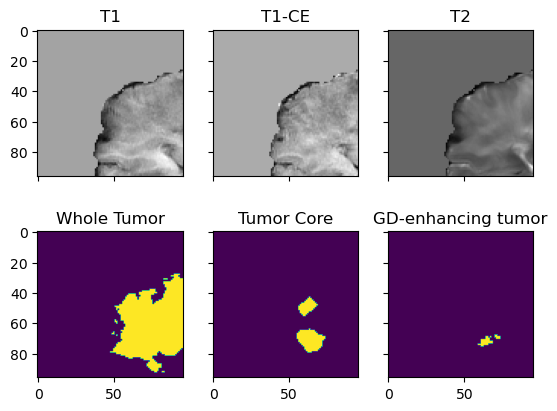

In [ ]:
# Visualising the Training Dataset per case

#! Misalignment of Seg and Image Tensors when using Orientationd

patient = 10  # Refers to a folder in the training dataset such as "./MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/"

slice = 40  # Refers to a slice in the 3D Tensor. For visualisation one of the 3 axis must be limited

sample = 0 # multiple random samples are taken per patient

to_plot_case = dataset_training[patient][sample]

fig, ax = plt.subplots(2, 3, sharey=True, sharex=True)

ax[0, 0].imshow(to_plot_case["image"][0][:, :, slice], cmap="gray",interpolation = 'antialiased')
ax[0, 0].set_title("T1")

ax[0, 1].imshow(to_plot_case["image"][1][:, :, slice], cmap="gray",interpolation = 'antialiased')
ax[0, 1].set_title("T1-CE")

ax[0, 2].imshow(to_plot_case["image"][2][:, :, slice], cmap="gray",interpolation = 'antialiased')
ax[0, 2].set_title("T2")


ax[1, 0].imshow(to_plot_case["seg"][0][:, :, slice])
ax[1, 0].set_title("Whole Tumor")

ax[1, 1].imshow(to_plot_case["seg"][1][:, :, slice])
ax[1, 1].set_title("Tumor Core")

ax[1, 2].imshow(to_plot_case["seg"][2][:, :, slice])
ax[1, 2].set_title("GD-enhancing tumor")


In [ ]:
del(dataset_training)

# Training and Validation of Model

### Preparing the Data Loaders

In [8]:
train_data_loader = DataLoader(
    Dataset(train_cases, transform_training_dataset),
    shuffle=True,
    batch_size=1,
    
)

#! transformation in validation dataset
val_data_loader = DataLoader(
    Dataset(val_cases[:30], transform_validation_dataset),
    shuffle=True,
    batch_size=1,
)


### Initialising the Model and Other Parameters

In [9]:
#! Pure Pytorch Training Loop:
# Ref: https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/brats_segmentation_3d.ipynb
# Ref: https://github.com/Project-MONAI/tutorials/blob/main/2d_segmentation/torch/unet_training_dict.py

clear_gpu_cache()

device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
print(f"Training will be done on {device}")

#! Update with proper values
max_epochs = 50
val_interval = 4

# model = SegResNet(
#     blocks_down=[1, 2, 2, 4],
#     blocks_up=[1, 1, 1],
#     init_filters=16,
#     in_channels=4,
#     out_channels=3,
#     dropout_prob=0.2,
#     spatial_dims=3,
# ).to(device)

model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=3,
    strides=(2, 2, 2),
    channels=(12, 24, 48, 96),
).to(device)

model_name = "UNet"


initial_lr = 1e-3

optimizer = torch.optim.Adam(model.parameters(), initial_lr, weight_decay=1e-5)
# optimizer = torch.optim.SGD(model.parameters(), initial_lr)

scaler = torch.cuda.amp.GradScaler()

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=max_epochs, eta_min=1e-4
)

# loss_function = DiceLoss(
#     smooth_nr=0, smooth_dr=1e-5, squared_pred=False, to_onehot_y=False, softmax=True
# )

loss_function = DiceCELoss(sigmoid=True, squared_pred=True)

# ? Check inferer parameters and tweak
def inference(input):
    """Do Sliding Window Inference on input tensor
    To avoid OOM Error, Input Model done on CPU.
    Patch taken from input and its inference done on GPU
    to speed up inference time.

    Args:
        input: Full input to pass in the model. For the case
        of this project size => (3,240,240,155)
    """

    def _compute(input):
        return sliding_window_inference(
            inputs=input.to("cpu"),
            roi_size=(96, 96, 96),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
            padding_mode="constant",
            sw_device="cuda:0",
            device="cpu",
        )

    with torch.cuda.amp.autocast():
        return _compute(input)


post_processing_validation = Compose(
    [Activations(sigmoid=True), AsDiscrete(threshold=0.5)]
)

dice_metric = DiceMetric(include_background=True, reduction="mean")
# dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")
# iou_metric = MeanIoU(include_background=True, reduction="mean_batch")


Deleting Model
Model Already Cleared
Clearing CUDA Cache
Done
Training will be done on cuda:0


### Load saved state from prev training to continue and initialise training parameters

In [10]:

# Set name to False if not loading
NAME_CHECKPOINT_FILE = "./checkpoint/best_metric_UNet_2023-01-15.pth"

try:
    checkpoint = torch.load(NAME_CHECKPOINT_FILE)

    #load the weights into the model, if the architecture has changed this will not work
    model.load_state_dict(checkpoint['model_state_dict'])

    #load the state of the optimiser, if the optimiser has changed this will not work
    optimizer.load_state_dict(checkpoint['optimiser_state_dict'])
except Exception:
    checkpoint = {}

epoch_continue = checkpoint.get("epoch",0)
epoch_loss_values = checkpoint.get("loss_per_epoch",[])
metric_values =  checkpoint.get("dice_metric_per_epoch",[])
best_metric = checkpoint.get("best_metric",-1)
best_metric_epoch = checkpoint.get("best_metric_epoch",0)


In [11]:
training_time = datetime.date(datetime.now()).__str__()
print(f"Beginning Training for {model_name}_{training_time}")


for epoch in range(epoch_continue, max_epochs):
    print("-" * 10)
    print(f"Epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in tqdm(train_data_loader):

        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["seg"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        step += 1

    #! Use Learning rate scheduler later for hyperparameter tuning
    lr_scheduler.step()
    epoch_loss /= step  # average epoch loss
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}\n")

    if (epoch + 1) % val_interval == 0:
        print(f"Validating Training at {(epoch + 1)} Epochs")
        model.eval()
        with torch.no_grad():
            for val_data in tqdm(val_data_loader):
                val_inputs, val_labels = (
                    val_data["image"],
                    val_data["seg"].to(device),
                )

                val_outputs = inference(val_inputs)

                val_outputs = [
                    post_processing_validation(i)
                    for i in decollate_batch(val_outputs.to(device))
                ]
                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            # metric_batch = dice_metric_batch.aggregate()
            # metric_tc = metric_batch[0].item()
            # metric_values_tc.append(metric_tc)
            # metric_wt = metric_batch[1].item()
            # metric_values_wt.append(metric_wt)
            # metric_et = metric_batch[2].item()
            # metric_values_et.append(metric_et)
            dice_metric.reset()
            # dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch
                torch.save(
                    {
                        "epoch": epoch,
                        "model_state_dict": model.state_dict(),
                        "optimiser_state_dict": optimizer.state_dict(),
                        "loss_per_epoch": epoch_loss_values,
                        "dice_metric_per_epoch": metric_values,
                        "best_metric": best_metric,
                        "best_metric_epoch": best_metric_epoch,
                    },
                    path.join(
                        "./checkpoint", f"best_metric_{model_name}_{training_time}.pth"
                    ),
                )
                print("saved new best metric model")
            else:
                # Update Num Epochs Trained
                # ? Should I just make a json file for each pth?
                checkpoint = torch.load(
                    f"./checkpoint/best_metric_{model_name}_{training_time}.pth"
                )
                checkpoint["epoch"] = epoch
                torch.save(
                    checkpoint,
                    f"./checkpoint/best_metric_{model_name}_{training_time}.pth",
                )
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                # f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )


Beginning Training for UNet_2023-01-15
----------
Epoch 4/50


100%|██████████| 265/265 [04:26<00:00,  1.00s/it]


epoch 4 average loss: 0.3997

Validating Training at 4 Epochs


100%|██████████| 30/30 [02:46<00:00,  5.54s/it]


current epoch: 4 current mean dice: 0.5542
best mean dice: 0.5544 at epoch: 3
----------
Epoch 5/50


100%|██████████| 265/265 [03:54<00:00,  1.13it/s]


epoch 5 average loss: 0.3770

----------
Epoch 6/50


100%|██████████| 265/265 [03:56<00:00,  1.12it/s]


epoch 6 average loss: 0.3623

----------
Epoch 7/50


100%|██████████| 265/265 [03:56<00:00,  1.12it/s]


epoch 7 average loss: 0.3518

----------
Epoch 8/50


100%|██████████| 265/265 [03:55<00:00,  1.12it/s]


epoch 8 average loss: 0.3423

Validating Training at 8 Epochs


100%|██████████| 30/30 [02:46<00:00,  5.56s/it]


saved new best metric model
current epoch: 8 current mean dice: 0.6613
best mean dice: 0.6613 at epoch: 7
----------
Epoch 9/50


100%|██████████| 265/265 [03:53<00:00,  1.13it/s]


epoch 9 average loss: 0.3425

----------
Epoch 10/50


100%|██████████| 265/265 [03:53<00:00,  1.13it/s]


epoch 10 average loss: 0.3306

----------
Epoch 11/50


100%|██████████| 265/265 [03:55<00:00,  1.12it/s]


epoch 11 average loss: 0.3221

----------
Epoch 12/50


100%|██████████| 265/265 [03:55<00:00,  1.13it/s]


epoch 12 average loss: 0.3165

Validating Training at 12 Epochs


100%|██████████| 30/30 [02:43<00:00,  5.44s/it]


saved new best metric model
current epoch: 12 current mean dice: 0.6946
best mean dice: 0.6946 at epoch: 11
----------
Epoch 13/50


100%|██████████| 265/265 [03:54<00:00,  1.13it/s]


epoch 13 average loss: 0.3129

----------
Epoch 14/50


100%|██████████| 265/265 [03:54<00:00,  1.13it/s]


epoch 14 average loss: 0.3077

----------
Epoch 15/50


100%|██████████| 265/265 [03:54<00:00,  1.13it/s]


epoch 15 average loss: 0.3008

----------
Epoch 16/50


100%|██████████| 265/265 [03:54<00:00,  1.13it/s]


epoch 16 average loss: 0.2994

Validating Training at 16 Epochs


100%|██████████| 30/30 [02:44<00:00,  5.49s/it]


saved new best metric model
current epoch: 16 current mean dice: 0.7423
best mean dice: 0.7423 at epoch: 15
----------
Epoch 17/50


100%|██████████| 265/265 [03:57<00:00,  1.11it/s]


epoch 17 average loss: 0.3066

----------
Epoch 18/50


100%|██████████| 265/265 [03:56<00:00,  1.12it/s]


epoch 18 average loss: 0.2881

----------
Epoch 19/50


100%|██████████| 265/265 [03:54<00:00,  1.13it/s]


epoch 19 average loss: 0.2834

----------
Epoch 20/50


100%|██████████| 265/265 [03:54<00:00,  1.13it/s]


epoch 20 average loss: 0.2841

Validating Training at 20 Epochs


100%|██████████| 30/30 [02:43<00:00,  5.44s/it]


current epoch: 20 current mean dice: 0.7188
best mean dice: 0.7423 at epoch: 15
----------
Epoch 21/50


100%|██████████| 265/265 [03:54<00:00,  1.13it/s]


epoch 21 average loss: 0.2821

----------
Epoch 22/50


100%|██████████| 265/265 [03:53<00:00,  1.13it/s]


epoch 22 average loss: 0.2774

----------
Epoch 23/50


100%|██████████| 265/265 [03:54<00:00,  1.13it/s]


epoch 23 average loss: 0.2734

----------
Epoch 24/50


100%|██████████| 265/265 [03:55<00:00,  1.13it/s]


epoch 24 average loss: 0.2718

Validating Training at 24 Epochs


100%|██████████| 30/30 [02:46<00:00,  5.56s/it]


saved new best metric model
current epoch: 24 current mean dice: 0.7817
best mean dice: 0.7817 at epoch: 23
----------
Epoch 25/50


100%|██████████| 265/265 [03:54<00:00,  1.13it/s]


epoch 25 average loss: 0.2670

----------
Epoch 26/50


100%|██████████| 265/265 [03:54<00:00,  1.13it/s]


epoch 26 average loss: 0.2639

----------
Epoch 27/50


100%|██████████| 265/265 [03:55<00:00,  1.12it/s]


epoch 27 average loss: 0.2627

----------
Epoch 28/50


100%|██████████| 265/265 [03:56<00:00,  1.12it/s]


epoch 28 average loss: 0.2633

Validating Training at 28 Epochs


100%|██████████| 30/30 [02:46<00:00,  5.55s/it]


current epoch: 28 current mean dice: 0.7358
best mean dice: 0.7817 at epoch: 23
----------
Epoch 29/50


100%|██████████| 265/265 [03:56<00:00,  1.12it/s]


epoch 29 average loss: 0.2585

----------
Epoch 30/50


100%|██████████| 265/265 [03:57<00:00,  1.12it/s]


epoch 30 average loss: 0.2538

----------
Epoch 31/50


100%|██████████| 265/265 [03:55<00:00,  1.13it/s]


epoch 31 average loss: 0.2533

----------
Epoch 32/50


100%|██████████| 265/265 [03:53<00:00,  1.13it/s]


epoch 32 average loss: 0.2505

Validating Training at 32 Epochs


100%|██████████| 30/30 [02:43<00:00,  5.45s/it]


current epoch: 32 current mean dice: 0.7732
best mean dice: 0.7817 at epoch: 23
----------
Epoch 33/50


100%|██████████| 265/265 [03:54<00:00,  1.13it/s]


epoch 33 average loss: 0.2492

----------
Epoch 34/50


100%|██████████| 265/265 [03:54<00:00,  1.13it/s]


epoch 34 average loss: 0.2485

----------
Epoch 35/50


100%|██████████| 265/265 [03:54<00:00,  1.13it/s]


epoch 35 average loss: 0.2463

----------
Epoch 36/50


100%|██████████| 265/265 [03:54<00:00,  1.13it/s]


epoch 36 average loss: 0.2453

Validating Training at 36 Epochs


100%|██████████| 30/30 [02:44<00:00,  5.49s/it]


current epoch: 36 current mean dice: 0.7812
best mean dice: 0.7817 at epoch: 23
----------
Epoch 37/50


100%|██████████| 265/265 [03:58<00:00,  1.11it/s]


epoch 37 average loss: 0.2438

----------
Epoch 38/50


100%|██████████| 265/265 [03:56<00:00,  1.12it/s]


epoch 38 average loss: 0.2411

----------
Epoch 39/50


100%|██████████| 265/265 [03:54<00:00,  1.13it/s]


epoch 39 average loss: 0.2401

----------
Epoch 40/50


100%|██████████| 265/265 [03:54<00:00,  1.13it/s]


epoch 40 average loss: 0.2390

Validating Training at 40 Epochs


100%|██████████| 30/30 [02:43<00:00,  5.46s/it]


current epoch: 40 current mean dice: 0.7772
best mean dice: 0.7817 at epoch: 23
----------
Epoch 41/50


100%|██████████| 265/265 [03:54<00:00,  1.13it/s]


epoch 41 average loss: 0.2383

----------
Epoch 42/50


100%|██████████| 265/265 [03:55<00:00,  1.13it/s]


epoch 42 average loss: 0.2375

----------
Epoch 43/50


100%|██████████| 265/265 [03:56<00:00,  1.12it/s]


epoch 43 average loss: 0.2357

----------
Epoch 44/50


100%|██████████| 265/265 [03:56<00:00,  1.12it/s]


epoch 44 average loss: 0.2352

Validating Training at 44 Epochs


100%|██████████| 30/30 [02:46<00:00,  5.54s/it]


current epoch: 44 current mean dice: 0.7795
best mean dice: 0.7817 at epoch: 23
----------
Epoch 45/50


100%|██████████| 265/265 [03:55<00:00,  1.13it/s]


epoch 45 average loss: 0.2335

----------
Epoch 46/50


100%|██████████| 265/265 [03:56<00:00,  1.12it/s]


epoch 46 average loss: 0.2324

----------
Epoch 47/50


100%|██████████| 265/265 [03:56<00:00,  1.12it/s]


epoch 47 average loss: 0.2335

----------
Epoch 48/50


100%|██████████| 265/265 [03:56<00:00,  1.12it/s]


epoch 48 average loss: 0.2320

Validating Training at 48 Epochs


100%|██████████| 30/30 [02:43<00:00,  5.46s/it]


saved new best metric model
current epoch: 48 current mean dice: 0.7821
best mean dice: 0.7821 at epoch: 47
----------
Epoch 49/50


100%|██████████| 265/265 [03:56<00:00,  1.12it/s]


epoch 49 average loss: 0.2321

----------
Epoch 50/50


100%|██████████| 265/265 [03:58<00:00,  1.11it/s]

epoch 50 average loss: 0.2301



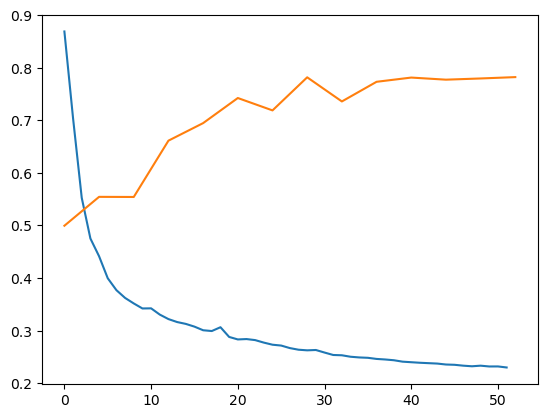

In [13]:
fig = plt.axes()
fig.plot(epoch_loss_values)
fig.plot([x*4 for x in range(len(metric_values))],metric_values)